In [1]:
# imports
import sqlalchemy
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, ForeignKey, case
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
import glob
import re
from os.path import isfile
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import gsw
import matplotlib.cm as cmm
import matplotlib.colors as col
import matplotlib.colors as col
import createDBfromDFO_OPDB
from netCDF4 import Dataset
%matplotlib inline

In [2]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'

In [3]:
# if PRISM.sqlite does not exist, run script to create it
if not isfile(basedir + dbname + '.sqlite'):
    import createDBfromDFO_OPDB
    createDBfromDFO_OPDB.main()
    import processDFO_OPDB
    processDFO_OPDB.main()
    print('done')
else:
    print('file exists')

file exists


In [4]:
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

In [5]:
Station=Base.classes.StationTBL
Obs=Base.classes.ObsTBL
JDFLocs=Base.classes.JDFLocsTBL
Calcs=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [6]:
Sal=case([(Obs.Salinity_Bottle!=None, Obs.Salinity_Bottle)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Salinity_T0_C0)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Salinity_T1_C1)], else_=
         case([(Obs.Salinity!=None, Obs.Salinity)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Salinity__Unknown)], else_=Obs.Salinity__Pre1978)
        ))))
SalUnits=case([(Obs.Salinity_Bottle!=None, Obs.Salinity_Bottle_units)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Salinity_T0_C0_units)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Salinity_T1_C1_units)], else_=
         case([(Obs.Salinity!=None, Obs.Salinity_units)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Salinity__Unknown_units)], else_=Obs.Salinity__Pre1978_units)
        ))))
SalFlag=case([(Obs.Salinity_Bottle!=None, Obs.Flag_Salinity_Bottle)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Flag_Salinity)], else_=Obs.Quality_Flag_Sali)
        ))))
SA=case([(Calcs.Salinity_Bottle_SA!=None, Calcs.Salinity_Bottle_SA)], else_=
         case([(Calcs.Salinity_T0_C0_SA!=None, Calcs.Salinity_T0_C0_SA)], else_=
         case([(Calcs.Salinity_T1_C1_SA!=None, Calcs.Salinity_T1_C1_SA)], else_=
         case([(Calcs.Salinity_SA!=None, Calcs.Salinity_SA)], else_=
         case([(Calcs.Salinity__Unknown_SA!=None, Calcs.Salinity__Unknown_SA)], else_=Calcs.Salinity__Pre1978_SA)
        ))))

In [7]:
NO=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite)], else_=Obs.Nitrate)
NOUnits=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite_units)], else_=Obs.Nitrate_units)
NOFlag=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Flag_Nitrate_plus_Nitrite)], else_=Obs.Flag_Nitrate)
# Obs.Quality_Flag_Nitr does not match any nitrate obs
# ISUS not included in this NO; test separately

In [8]:
q=session.query(NO,NOFlag, func.count()).group_by(NOFlag).all()
for t, tf, c in q:
    print(t,tf,c)

30.52 None 47579
37.7  10
29.8 0 34626
18.3 16 10
18.0 2 25
16.5 3 490
1.17 36 54
24.7 4 215
12.6 46 1
27.1 6 2385
34.66 62 2
28.6 63 29
None 9 7


In [13]:
q=session.query(NO,NOUnits, func.count()).group_by(NOUnits).all()
# note: all of these units are equivalent
for t, tf, c in q:
    print(t,tf,c)

None None 25703
30.52 microg-at/l 3180
35.0 mmol/m**3 2896
24.7 umol/L 53654


In [14]:
q=session.query(Obs.Silicate,Obs.Silicate_units, func.count()).group_by(Obs.Silicate_units).all()
# note: all of these units are equivalent
for t, tf, c in q:
    print(t,tf,c)

None None 16657
61.61 microg-at/l 3180
66.0 mmol/m**3 6020
41.4 umol/L 59576


In [10]:
Press=case([(Obs.Pressure!=None, Obs.Pressure)], else_=Obs.Pressure_Reversing)

In [8]:
Tem=case([(Obs.Temperature!=None, Obs.Temperature)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary)], else_=Obs.Temperature_Reversing)))
TemUnits=case([(Obs.Temperature!=None, Obs.Temperature_units)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary_units)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary_units)], 
              else_=Obs.Temperature_Reversing_units)))
TemFlag=Obs.Quality_Flag_Temp

In [10]:
q=session.query(Tem,TemFlag, func.count()).group_by(TemFlag).all()
for t, tf, c in q:
    print(t,tf,c)

8.93 None 64398
7.98 0. 699
5.5 1. 19462
10.9 2. 500
17.26 3. 192
None 9. 182


In [11]:
q=session.query(Tem,TemUnits, func.count()).group_by(TemUnits).all()
for t, tf, c in q:
    print(t,tf,c)

None None 574
8.93 'DEG_C' 3078
6.84 'deg_C' 6185
5.6 'deg_C_(IPTS68)' 7112
9.1711 'deg_C_(ITS90)' 47631
5.5 Degrees_C 20853


In [9]:
Ox=case([(Calcs.Oxygen_umolL!=None, Calcs.Oxygen_umolL)], else_=Calcs.Oxygen_Dissolved_umolL)
OxFlag=case([(Calcs.Oxygen_umolL!=None, Obs.Quality_Flag_Oxyg)], else_=Obs.Flag_Oxygen_Dissolved)

In [11]:
# TS diagram based on example code, but using SA and CT
q=session.query(JDFLocs.ObsID, Obs.ID, SA, Tem, Press).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).filter(and_(
            SA!=None,
            SA>0,
            SA<50,
            Tem!=None,
            Press!=None)).all()
ID1=[]
ID2=[]
S_A=[]
TC=[]
P=[]
for ID1x, ID2x, S_Ax, Tx, Px in q:
    S_A.append(float(S_Ax))
    TC.append(gsw.CT_from_t(S_Ax,Tx,Px))
S_A=np.array(S_A)
TC=np.array(TC)

/home/eolson/anaconda3/envs/teos10/lib/python3.4/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


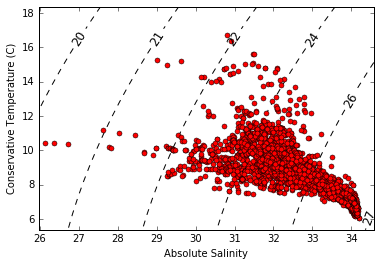

In [12]:
# TS diagram example:

# Create variables with user-friendly names
temp  = TC
salt  = S_A
 
# Figure out boudaries (mins and maxs)
smin = salt.min() - (0.01 * salt.min())
smax = salt.max() + (0.01 * salt.max())
tmin = temp.min() - (0.1 * temp.max())
tmax = temp.max() + (0.1 * temp.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = round((smax-smin)/0.1+1,0)
ydim = round((tmax-tmin)+1,0)
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],gsw.t_from_CT(si[i],ti[j],0),0)
 
# Substract 1000 to convert to sigma-t
dens = dens - 1000
 
# Plot data ***********************************************
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%1.0f') # Label every second level
 
ax1.plot(salt,temp,'or',markersize=5)
 
ax1.set_xlabel('Absolute Salinity')
ax1.set_ylabel('Conservative Temperature (C)')

# Ammonium: use Obs.Ammonium (umol/L)

In [13]:
q=session.query(Obs.Ammonia, Obs.Ammonia_units, Obs.Ammonium, Obs.Ammonium_units, func.count()).\
        filter(or_(Obs.Ammonia!=None,Obs.Ammonium!=None)).\
        group_by(Obs.Ammonia_units,Obs.Ammonium_units).all()
for row in q:
    print(row)

(None, None, 0.16, 'umol/L', 3051)
(0.7, 'microg-at/l', None, None, 1163)


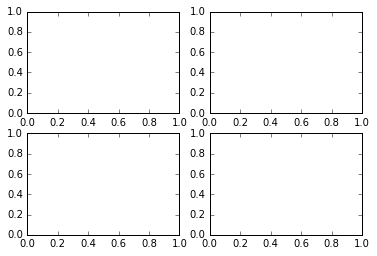

In [14]:
fig, axs = plt.subplots(2,2)

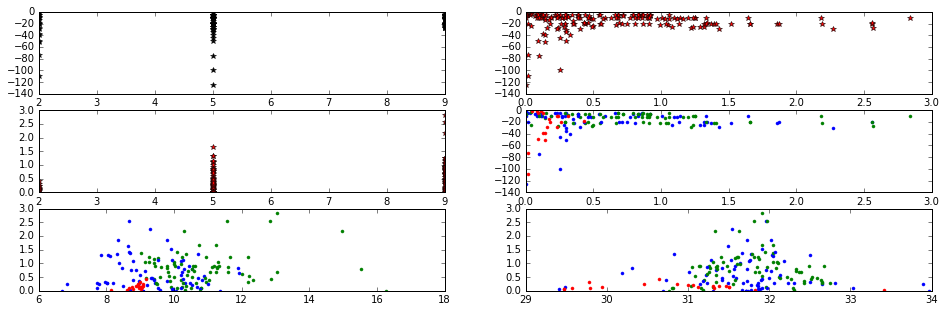

In [15]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press, Obs.Depth,
                Obs.Ammonium,Obs.Ammonium_units,Tem,Sal).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Ammonium!=None).all()
fig, axs = plt.subplots(3,2,figsize=(16,5))
for row in q:
    #print(row)
    axs[0,0].plot(row[2],-row[3],'k*')
    axs[0,1].plot(row[5],-row[3],'r*')
    if row[3]<20:
        axs[1,0].plot(row[2],row[5],'r*')
    if row[2]==5:
        axs[1,1].plot(row[5],-row[3],'b.')
        axs[2,0].plot(row[7],row[5],'b.')
        axs[2,1].plot(row[8],row[5],'b.')
    elif row[2]==2:
        axs[1,1].plot(row[5],-row[3],'r.')
        axs[2,0].plot(row[7],row[5],'r.')
        axs[2,1].plot(row[8],row[5],'r.')
    else:
        axs[1,1].plot(row[5],-row[3],'g.')
        axs[2,0].plot(row[7],row[5],'g.')
        axs[2,1].plot(row[8],row[5],'g.')

DON:

In [16]:
q=session.query(Station.StartYear,Station.StartMonth,Press, Station.Lat, Station.Lon,Obs.Depth,
                Obs.Nitrogen_Dissolved_Organic,Obs.Nitrogen_Dissolved_Organic_units,Tem,Sal).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Nitrogen_Dissolved_Organic!=None).filter(Obs.Nitrogen_Dissolved_Organic>=0).\
        filter(Station.Lat!=None).filter(Station.Lon!=None).\
        filter(Station.Lat<48.8).filter(Station.Lon<-125).all()

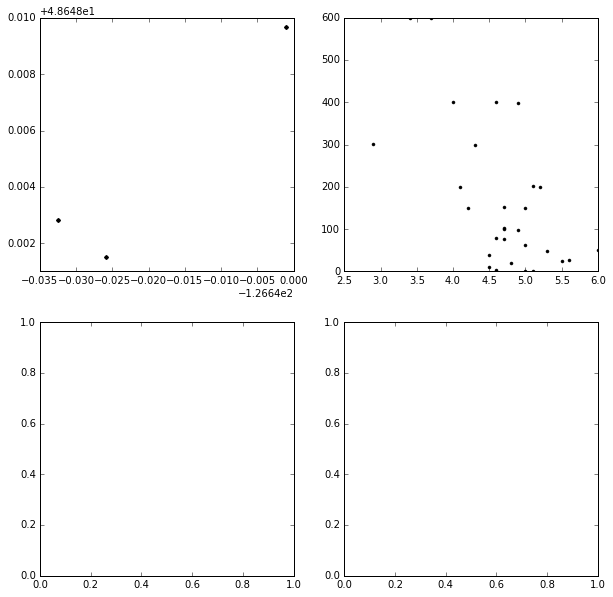

In [17]:

fig, axs = plt.subplots(2,2,figsize=(10,10))
for row in q:
    axs[0,0].plot(row[4],row[3],'k.')
    axs[0,1].plot(row[6],row[2],'k.')

In [18]:
q=session.query(JDFLocs.ObsID,Station.StartYear,Station.StartMonth,Press,
                func.avg(NO)).\
        select_from(Obs).join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).\
        join(Station,Station.ID==Obs.StationTBLID).\
        filter(NO!=None).filter(NO>=0).\
        filter(Press<10).filter(Press!=None).filter(Press>=0).group_by(Station.StartMonth).all()

(25699, 2002.0, 1.0, 5.2, 9.766666666666666)
(29621, 2003.0, 2.0, 5.0, 4.442857142857143)
(35731, 2005.0, 3.0, 9.9, 3.0750000000000006)
(59417, 2000.0, 4.0, 9.6, 11.92420289855072)
(42809, 2008.0, 5.0, 4.8, 8.002678571428572)
(41644, 2007.0, 6.0, 6.5, 17.761818181818178)
(60008, 2000.0, 7.0, 5.4, 22.7875)
(60296, 2000.0, 8.0, 1.7, 13.963636363636363)
(43267, 2008.0, 9.0, 4.3, 19.37224137931034)
(41941, 2007.0, 10.0, 6.9, 17.389411764705883)
(42247, 2007.0, 11.0, 6.6, 12.955555555555556)
(35178, 2004.0, 12.0, 9.8, 7.321052631578948)


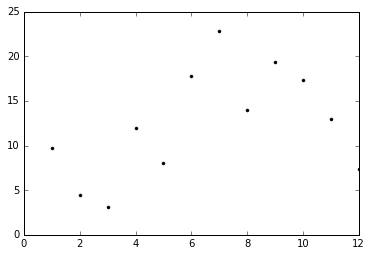

In [19]:
for row in q:
    print(row)
    plt.plot(row[2],row[4],'k.')

In [20]:
q=session.query(JDFLocs.ObsID,Station.StartYear,Station.StartMonth,Station.StartDay, Press,NO,NOUnits).\
        select_from(Obs).join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).\
        join(Station,Station.ID==Obs.StationTBLID).\
        filter(NO!=None).filter(NO>=0).\
        filter(Press<10).filter(Press!=None).group_by(NOUnits).all()
for row in q:
    print(row)

(60296, 2000.0, 8.0, 29.0, 1.7, 19.6, 'umol/L')


In [21]:
import datetime as dt

In [22]:
q=session.query(JDFLocs.ObsID,Station.StartYear,Station.StartMonth,Station.StartDay, Press,Obs.Nitrate_plus_Nitrite).\
        select_from(Obs).join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).\
        join(Station,Station.ID==Obs.StationTBLID).\
        filter(NO!=None).filter(NO>=0).\
        filter(Press<10).filter(Press!=None).all()

In [23]:
qYr=[]
qNO=[]
qP=[]
date=[]
for OID, Yr, Mn, dy, P, NO3 in q:
    qYr.append(Yr)
    qP.append(P)
    qNO.append(NO3)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))

qP=np.array(qP)
qNO=np.array(qNO)
date=np.array(date)
YD=0.0*qP
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

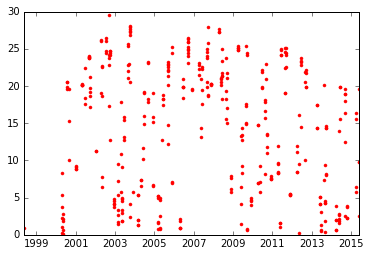

In [24]:
plt.plot(date,qNO,'r.')

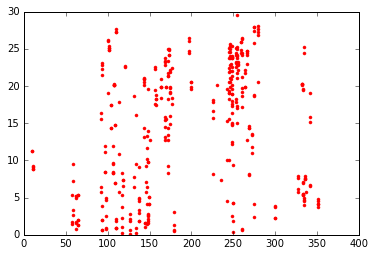

In [25]:
plt.plot(YD,qNO,'r.')

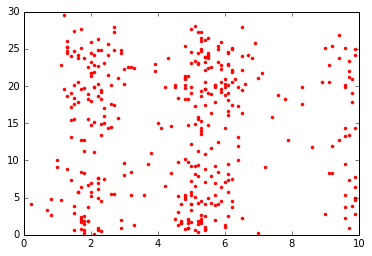

In [26]:
plt.plot(qP,qNO,'r.')

In [27]:
q=session.query(JDFLocs.ObsID, Obs.ID, SA, Sal, Tem, Press).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).filter(and_(
            SA!=None,
            Tem!=None,
            Press!=None)).filter(SA>40).all()
for row in q:
    print(row)

(6334, 6334, 54.82919511370604, 54.5674, 10.6817, 27.6)


In [28]:
q=session.query(JDFLocs.ObsID, Obs.sourceFile, Obs.Depth, SA, Obs.Salinity_Bottle, Obs.Salinity, Obs.Salinity_T0_C0, 
               Obs.Salinity_T1_C1, Obs.Salinity__Pre1978, Obs.Salinity__Unknown).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).filter(and_(
            SA!=None,
            Tem!=None,
            Press!=None)).filter(SA>40).all()
for row in q:
    print(row)

(6334, 'UBC EO data request 20160113 a/2010-21-0009.che', None, 54.82919511370604, None, None, 54.5674, None, None, None)


In [29]:
qJDFLoc=session.query(Obs.ID, Station.ID).filter(
    and_(
        Station.Lat > 48.2,
        Station.Lat < 48.8,
        Station.Lon > -125.2,
        Station.Lon < -124.2
        )).join(Station, Obs.StationTBLID==Station.ID)
print(qJDFLoc.count())

3404


# Look at spatial and temporal distribution of NO3 measurements

In [11]:
q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, NO).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
            NO!=None,
            Station.Lat!=None,
            Station.Lon!=None,
            Station.StartMonth!=None,
            Press>800,
            Press>1000))
print(q.count())

1492


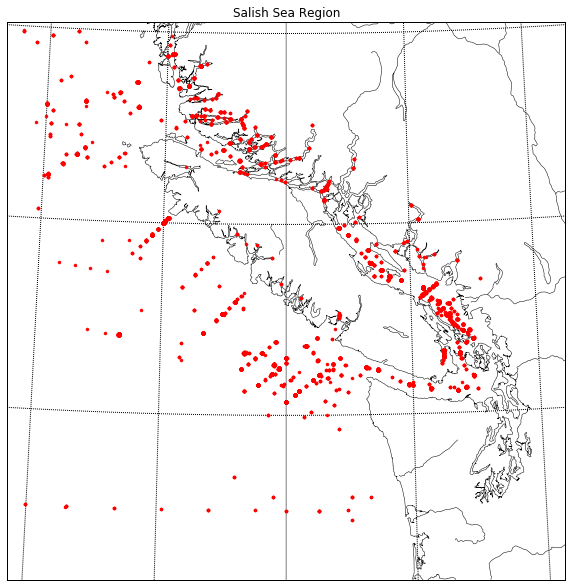

In [12]:
# map:
width = 650000; lon_0 = -126; lat_0 = 49.2
plt.figure(figsize=(10,10))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary()
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(40,60,2))
m.drawmeridians(np.arange(-130,-110,2))
plt.title('Salish Sea Region')

q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, NO).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
            NO!=None,
            Station.Lat!=None,
            Station.Lon!=None,
            Station.StartMonth!=None,
            Press>100,
            Press<200))
for Lat, Lon, Y, M, D, P, N in q.all():
    if Lon>0:
        Lon=-Lon
    xpt, ypt = m(Lon, Lat)
    m.plot([xpt],[ypt],'r.')

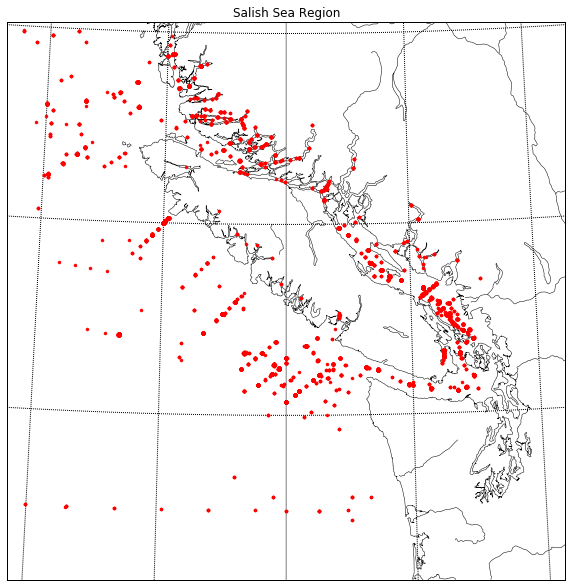

In [13]:
# map:
width = 650000; lon_0 = -126; lat_0 = 49.2
plt.figure(figsize=(10,10))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary()
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(40,60,2))
m.drawmeridians(np.arange(-130,-110,2))
plt.title('Salish Sea Region')

q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, NO).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
            NO!=None,
            Station.Lat!=None,
            Station.Lon!=None,
            Station.StartMonth!=None,
            Press>100,
            Press<200))
for Lat, Lon, Y, M, D, P, N in q.all():
    if Lon>0:
        Lon=-Lon
    xpt, ypt = m(Lon, Lat)
    m.plot([xpt],[ypt],'r.')

In [30]:
# read in etopo5 topography/bathymetry.
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)

In [22]:

norm = col.Normalize(vmin=20.,vmax=35)

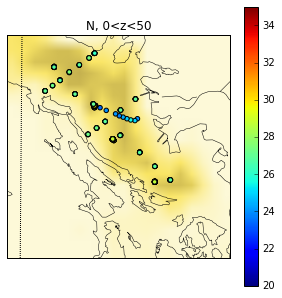

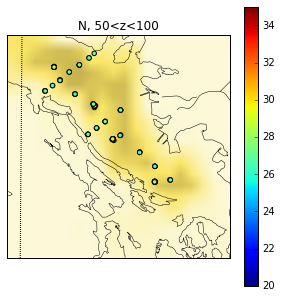

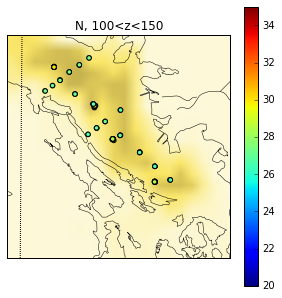

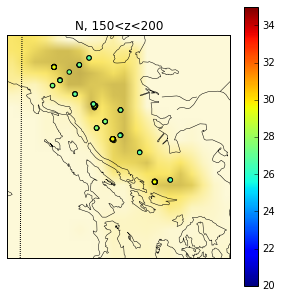

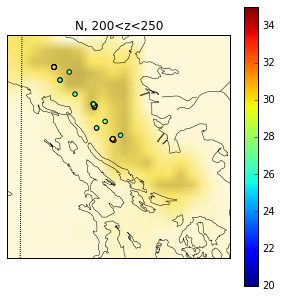

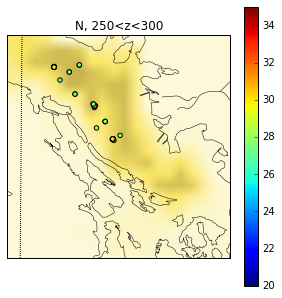

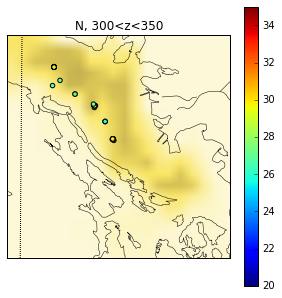

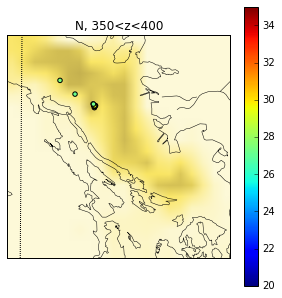

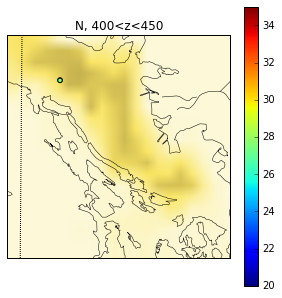

In [37]:


dz=50
for iz in range(9):
    # map:
    width =100000; 
    lon_0 = -123.4; lat_0 = 49.0
    plt.figure(figsize=(5,5))
    m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
                lat_0=lat_0,lon_0=lon_0)
    # transform to nx x ny regularly spaced 5km native projection grid
    nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
    topodat = m.transform_scalar(topoin,lons,lats,nx,ny)
    # plot image over map with imshow.
    im = m.imshow(topodat,cm.GMT_relief,clim=(-600, 0))
    # fill background.
    m.drawmapboundary()
    # draw coasts and fill continents.
    m.drawcoastlines(linewidth=0.5)
    m.drawrivers()
    #m.shadedrelief()
    # 20 degree graticule.
    m.drawparallels(np.arange(40,60,2))
    m.drawmeridians(np.arange(-130,-110,2))
    q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, NO).\
            select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
                or_(
                Station.StartMonth==11,
                Station.StartMonth==12,
                Station.StartMonth==1),
                NO!=None,
                Station.Lat!=None,
                Station.Lon!=None,
                Station.Lat>48.8,
                Station.Lat<49.5,
                Station.Lon>-124,
                Station.Lon<-123,
                Station.StartMonth!=None,
                Press>(iz*dz),
                Press<(iz+1)*dz))
    Lats=[]
    Lons=[]
    Ys=[]
    Ms=[]
    Ds=[]
    Ps=[]
    Ns=[]
    for Lat, Lon, Y, M, D, P, N in q.all():
        if Lon>0:
            Lon=-Lon
        Lats.append(Lat)
        Lons.append(Lon)
        Ys.append(Y)
        Ms.append(M)
        Ds.append(D)
        Ps.append(P)
        Ns.append(float(N))
    N2=np.array(Ns)
    #print(Ns)
    xpt, ypt = m(Lons, Lats)
    m.scatter(xpt,ypt,c=N2,norm=norm)
    plt.title('N, '+str(iz*dz)+'<z<'+str((iz+1)*dz))
    plt.colorbar()

In [12]:
q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, NO).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
            NO!=None,
            Station.Lat!=None,
            Station.Lon!=None,
            Station.Lat>48.8,
            Station.Lat<49.5,
            Station.Lon>-124,
            Station.Lon<-123,
            Station.StartMonth!=None))
lats=[]
lons=[]
Ys=[]
Ms=[]
Ds=[]
Ps=[]
Ns=[]
for Lat, Lon, Y, M, D, P, N in q.all():
    if Lon>0:
        Lon=-Lon
    lats.append(Lat)
    lons.append(Lon)
    Ys.append(Y)
    Ms.append(M)
    Ds.append(D)
    Ps.append(P)
    Ns.append(float(N))

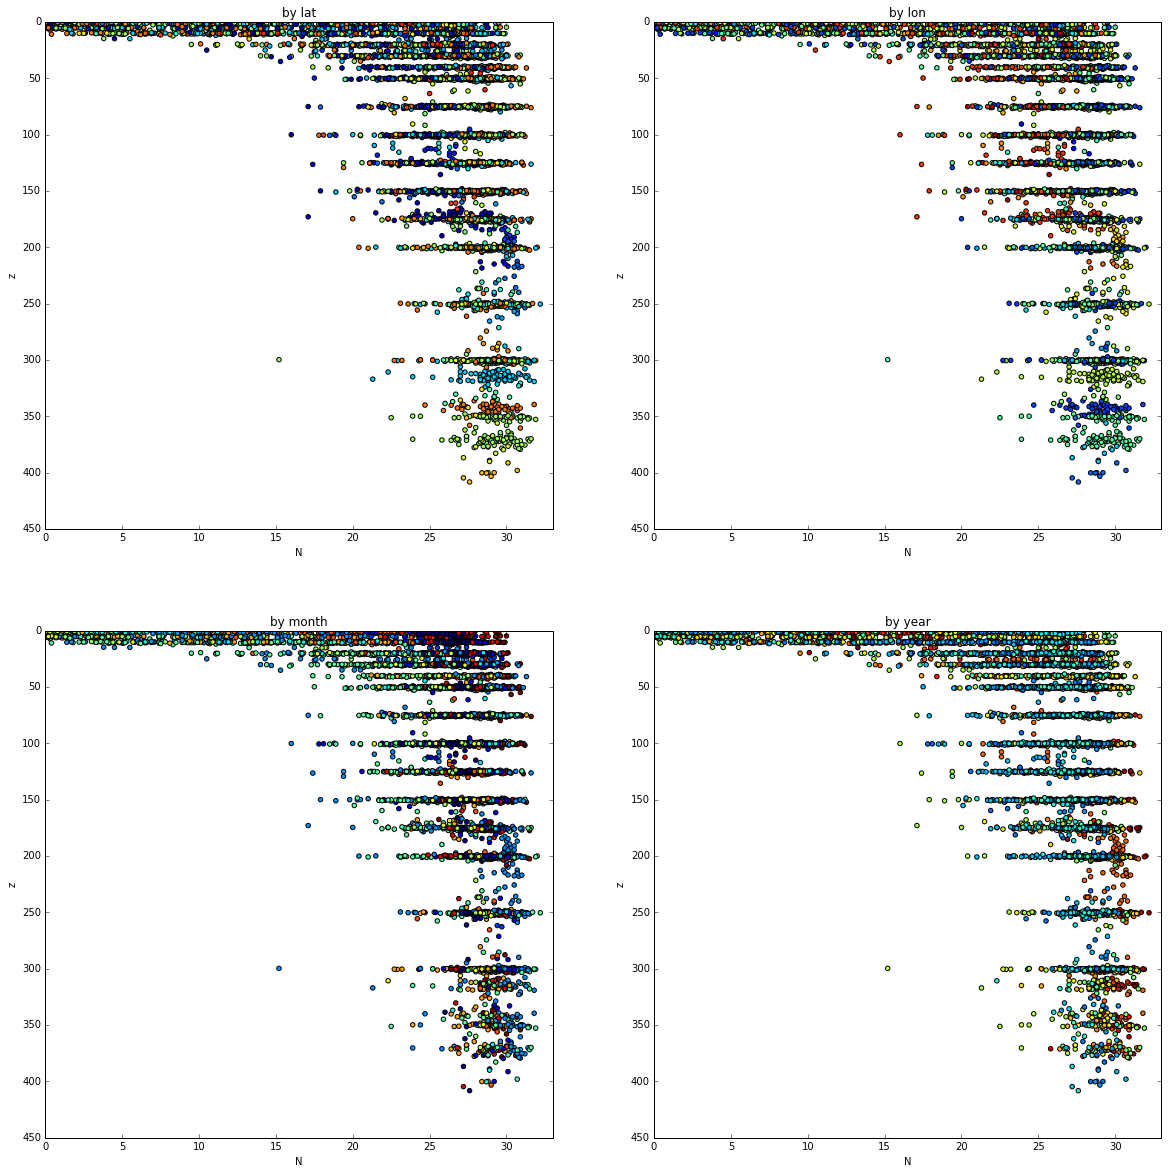

In [22]:
fig, ax=plt.subplots(2,2,figsize=(20,20))
ax[0,0].invert_yaxis()
ax[0,0].scatter(Ns,Ps,c=lats)
ax[0,0].axis([0,33,450,0])
ax[0,0].set_title('by lat')
ax[0,0].set_xlabel('N')
ax[0,0].set_ylabel('z')

ax[0,1].invert_yaxis()
ax[0,1].scatter(Ns,Ps,c=lons)
ax[0,1].axis([0,33,450,0])
ax[0,1].set_title('by lon')
ax[0,1].set_xlabel('N')
ax[0,1].set_ylabel('z')

ax[1,0].invert_yaxis()
ax[1,0].scatter(Ns,Ps,c=Ms)
ax[1,0].axis([0,33,450,0])
ax[1,0].set_title('by month')
ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel('z')

ax[1,1].invert_yaxis()
ax[1,1].scatter(Ns,Ps,c=Ys,vmin=1990,vmax=2015)
ax[1,1].axis([0,33,450,0])
ax[1,1].set_title('by year')
ax[1,1].set_xlabel('N')
ax[1,1].set_ylabel('z')

In [23]:
q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, NO).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
            NO!=None,
            Station.Lat!=None,
            Station.Lon!=None,
            Station.Lat>48.8,
            Station.Lat<49.5,
            Station.Lon>-124,
            Station.Lon<-123,
            Station.StartMonth>=1,
            Station.StartMonth<=3 ))
lats=[]
lons=[]
Ys=[]
Ms=[]
Ds=[]
Ps=[]
Ns=[]
for Lat, Lon, Y, M, D, P, N in q.all():
    if Lon>0:
        Lon=-Lon
    lats.append(Lat)
    lons.append(Lon)
    Ys.append(Y)
    Ms.append(M)
    Ds.append(D)
    Ps.append(P)
    Ns.append(float(N))

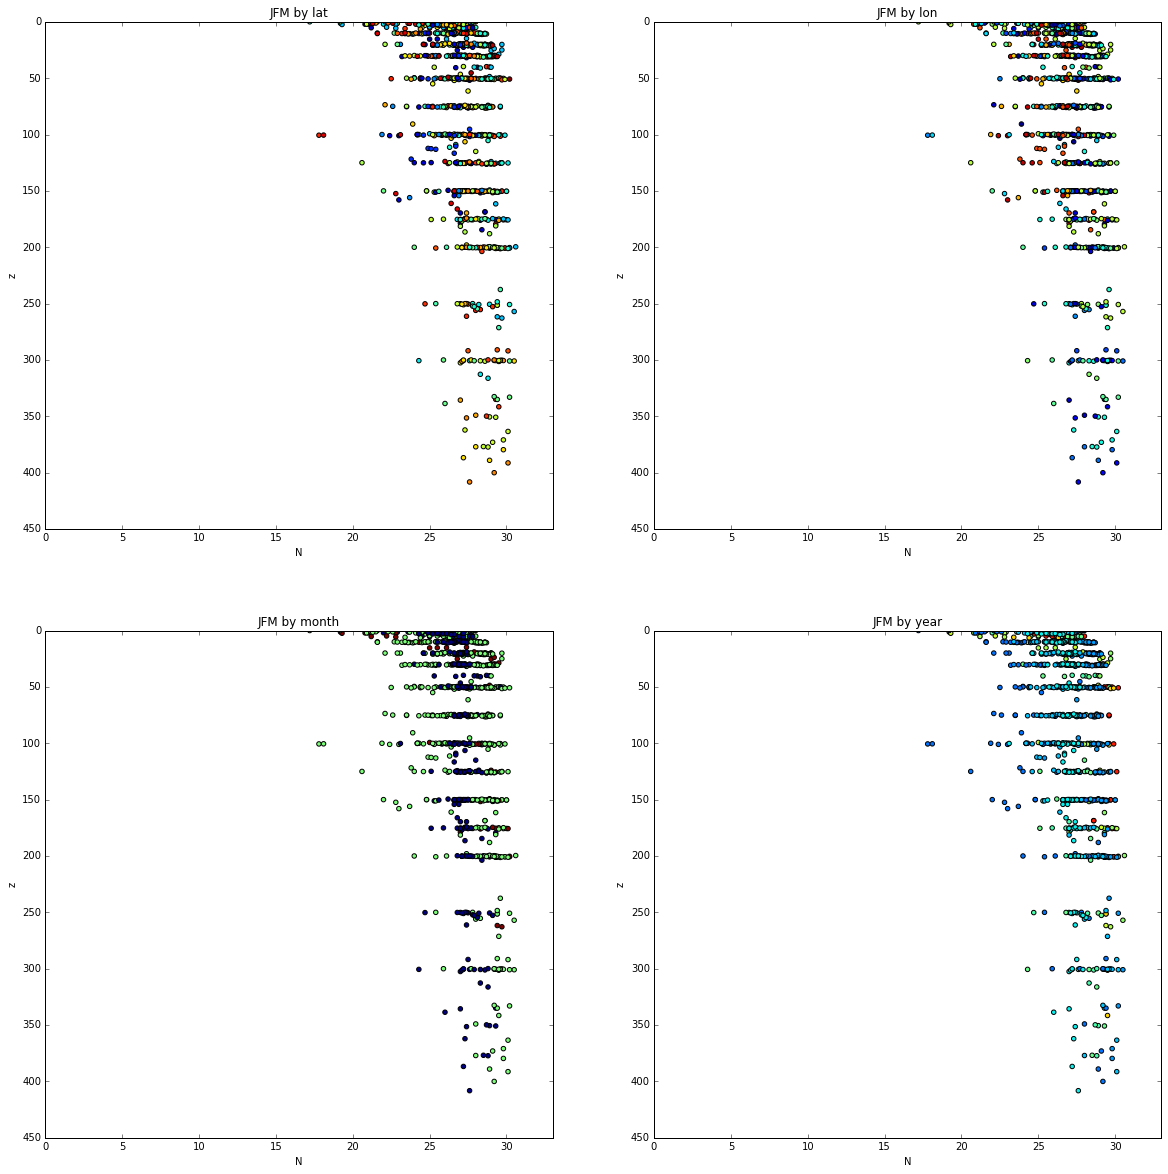

In [26]:
fig, ax=plt.subplots(2,2,figsize=(20,20))
ax[0,0].invert_yaxis()
ax[0,0].scatter(Ns,Ps,c=lats)
ax[0,0].axis([0,33,450,0])
ax[0,0].set_title('JFM by lat')
ax[0,0].set_xlabel('N')
ax[0,0].set_ylabel('z')

ax[0,1].invert_yaxis()
ax[0,1].scatter(Ns,Ps,c=lons)
ax[0,1].axis([0,33,450,0])
ax[0,1].set_title('JFM by lon')
ax[0,1].set_xlabel('N')
ax[0,1].set_ylabel('z')

ax[1,0].invert_yaxis()
ax[1,0].scatter(Ns,Ps,c=Ms)
ax[1,0].axis([0,33,450,0])
ax[1,0].set_title('JFM by month')
ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel('z')

ax[1,1].invert_yaxis()
ax[1,1].scatter(Ns,Ps,c=Ys,vmin=1990,vmax=2015)
ax[1,1].axis([0,33,450,0])
ax[1,1].set_title('JFM by year')
ax[1,1].set_xlabel('N')
ax[1,1].set_ylabel('z')

In [21]:
print(np.min(Ys),np.max(Ys))

1931.0 2015.0


In [ ]:

width =100000; 
lon_0 = -123.4; lat_0 = 49.0
plt.figure(figsize=(5,5))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary()
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(40,60,2))
m.drawmeridians(np.arange(-130,-110,2))


m.scatter(xpt,ypt,c=N2)
#plt.title('N, '+str(iz*dz)+'<z<'+str((iz+1)*dz))
m.colorbar

In [17]:
print(xpt)

21079.16148316676


None 0.0 30.9
None 50.0 6.5
None 100.0 9.6
None 150.0 6.0
None 210.0 11.8
None 0.0 34.3
None 50.0 4.7
None 100.0 9.1
None 150.0 4.7
None 217.0 11.6
None 0.0 20.1
None 50.0 3.7
None 100.0 11.1
None 150.0 3.2
None 208.0 9.8
None 0.0 22.1
None 50.0 4.3
None 100.0 11.1
None 150.0 3.4
None 189.0 5.1
None 0.0 15.4
None 50.0 3.8
None 100.0 5.6
None 150.0 3.2
None 170.0 3.9
None 0.0 15.5
None 50.0 4.4
None 100.0 6.4
None 150.0 3.9
None 157.0 4.4
None 0.0 34.0
None 50.0 10.9
None 100.0 15.7
None 150.0 16.7
None 200.0 14.1
None 210.0 29.3
None 215.0 48.1
None 0.0 64.2
None 50.0 7.5
None 100.0 11.3
None 150.0 29.6
None 200.0 13.3
None 210.0 14.3
None 215.0 47.8
None 219.0 22.8
None 0.0 26.0
None 50.0 5.0
None 100.0 6.8
None 150.0 11.6
None 200.0 11.1
None 217.0 15.4
None 222.0 15.2
None 226.0 14.2
None 0.0 23.6
None 50.0 6.9
None 100.0 9.1
None 150.0 6.5
None 200.0 9.8
None 208.0 13.2
None 213.0 11.6
None 217.0 12.1
None 0.0 15.3
None 50.0 7.4
None 100.0 9.5
None 150.0 9.9
None 189.0 8.8
None 194

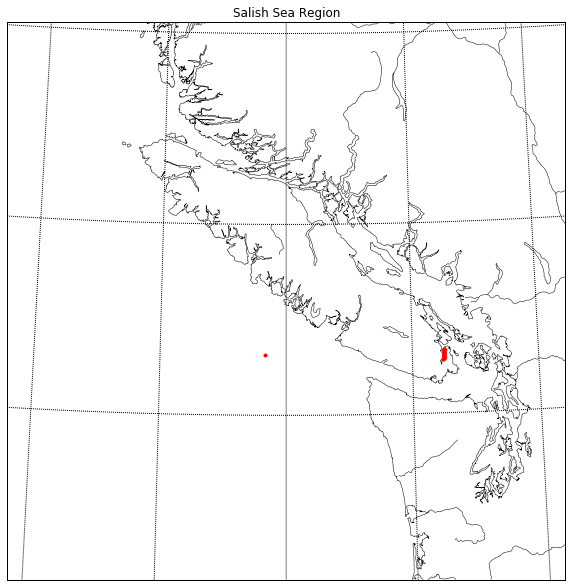

In [15]:
# map:
width = 650000; lon_0 = -126; lat_0 = 49.2
plt.figure(figsize=(10,10))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',
            lat_0=lat_0,lon_0=lon_0)
# fill background.
m.drawmapboundary()
# draw coasts and fill continents.
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(40,60,2))
m.drawmeridians(np.arange(-130,-110,2))
plt.title('Salish Sea Region')

q=session.query(Station.Lat, Station.Lon, Station.StartYear, Station.StartMonth, Station.StartDay, Press, Obs.Nitrogen_Particulate_Organic, Obs.Depth).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).filter(and_(
            Obs.Nitrogen_Particulate_Organic!=None,
            Station.Lat!=None,
            Station.Lon!=None,
            Station.StartMonth!=None))
for Lat, Lon, Y, M, D, P, N, Z in q.all():
    if Lon>0:
        Lon=-Lon
    xpt, ypt = m(Lon, Lat)
    m.plot([xpt],[ypt],'r.')
    print(P,Z,N)

In [33]:
test=session.query(Obs.ID)
print(test.count())

85433


In [ ]:
Lat=[]
Lon=[]
z=[]
P=[]
T=[]
S=[]
N=[]
O=[]
for row in qdata.all():
    Lat.append(row[1])
    Lon.append(row[2])
    z.append(row[3])
    P.append(row[4])
    T.append(float(row[5]))
    S.append(float(row[6]))
    N.append(float(row[7]))
    O.append(float(row[8]))

In [ ]:
print(T[0])

In [ ]:
N=np.array(N)
S=np.array(S)
T=np.array(T)
O=np.array(O)

In [ ]:
plt.plot(S,N,'.')
plt.xlabel('S')
plt.ylabel('N')

In [ ]:
plt.plot(T,N,'.')
plt.xlabel('T')
plt.ylabel('N')

In [ ]:
plt.plot(O,N,'.')
plt.xlabel('O')
plt.ylabel('N')

In [ ]:
a=np.vstack([T,S,O,np.ones(len(T))]).T
m = np.linalg.lstsq(a,N)[0]
mT, mS, mO, mC = m
print(mT, mS, mO, mC)

In [ ]:
plt.plot(N,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((NO-np.dot(a,m)),(NO-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S)')
print('SSE=', SSE)
plt.plot(np.array([0,40]), np.array([0, 40]),'r-')

In [ ]:
session.close()
engine.dispose()